In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import emcee
sb.set_style('white')
%config InlineBackend.figure_format = 'retina'

In [2]:
import sys
sys.path.insert(0, '../Primarios')

In [3]:
from Ocentauri import interp

In [4]:
from scipy.interpolate import interp1d

In [5]:
def EdNdE_primary(mass,energy,col):
    #val1,val2 = interp(mass,col)
    a=interp1d(interp(mass,col)[0],interp(mass,col)[1],fill_value='extrapolate')
    return a(energy)

In [6]:
def phi_primary(pars,energy,col):
    mass,log_sig,log_J= pars
    
    sigmav = 10.**log_sig
    J = 10.**log_J
    probe = energy/(1000.)
    
    var = J*(1./(4.*np.pi))*sigmav*EdNdE_primary(mass,probe,col)/(2.*(mass**2))
    
    return energy*(1000.)*(1.602e-6)*var

In [7]:
def E2dNdE_pulsar(pars,energy):
    Gamma,log_E,log_N = pars
    #Gamma=0.7
    #energy_cut=1.2*1000.
    #No = 1e-11
    #Gamma = 10.**log_g
    energy_cut = 10.**log_E
    No = 10.**log_N
    return No*(energy**2)*(energy**(-1.0*Gamma))*np.exp((-1.0)*energy/energy_cut)

In [8]:
def lnhood(pars,data,err,energy,col='col14'):
    #model = phi_primary(pars,energy,col)
    model = E2dNdE_pulsar(pars,energy)
    p = (((data - model)**2) / err) + np.log(2. * np.pi * err)
    
    return -0.5*np.sum(p)

In [9]:
def priors(pars,plist):
    mass,log_sig,log_J = pars
    
    if plist[0]<mass<plist[1] and plist[2]<log_sig<plist[3] and\
    plist[4]<log_J<plist[5]:
        return 0.0
    return -np.inf

In [10]:
def pulsar_priors(pars,plist):
    Gamma, log_E,log_N = pars
    
    if plist[0]<Gamma<plist[1] and plist[2]<log_E<plist[3] and plist[4]<log_N<plist[5]:
        return 0.0
    return -np.inf

In [11]:
def lnpost(pars,data,err,energy,plist):
    pi = pulsar_priors(pars, plist)
    if not np.isfinite(pi):
        return -np.inf
    return pi+lnhood(pars,data,err,energy)

In [12]:
E,flux,error_u,error_d,e1,e2 = np.loadtxt('data_flux.txt',unpack=True)

In [13]:
error = error_u**2 + error_d**2

In [14]:
flux = flux*pow(E,2)

In [15]:
np.log10(1200)

3.0791812460476247

(100, 7000)

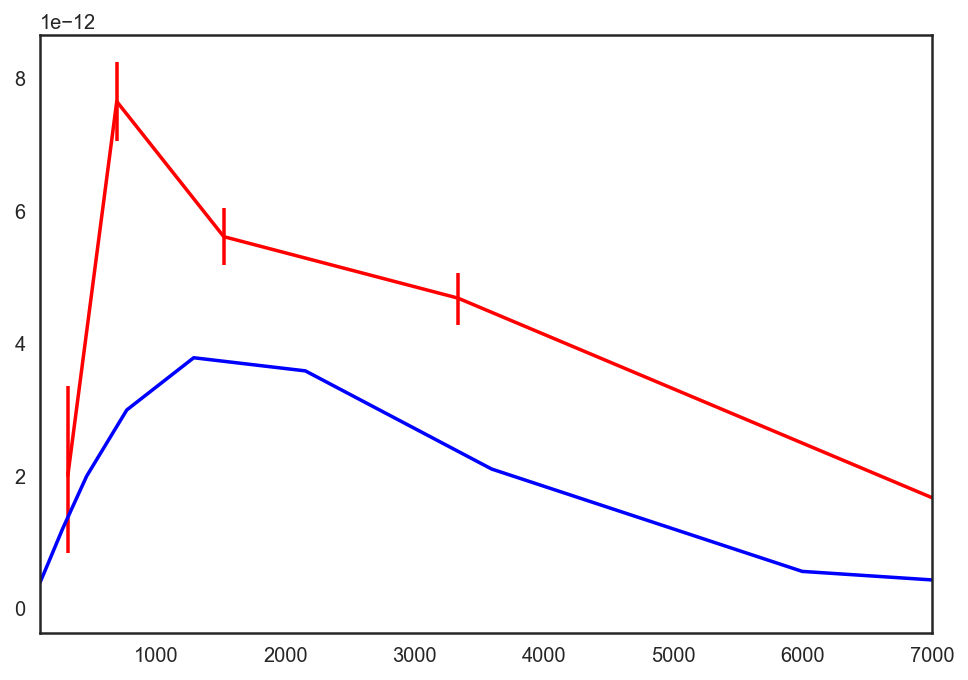

In [16]:
x=np.logspace(2,4,10)
plt.plot(x,E2dNdE_pulsar(np.log10([10**0.7, 1200.,1e-15]), x),'b');
#plt.loglog(E,flux,'r');
plt.errorbar(E,flux,[error_u,error_d],color='r');
plt.xlim(100,7000)

In [17]:
#p_list = [5.,150., -29.,-23., 18.,22.]
#bnds = ((5.,150.), (-29.,-23.), (18.,22.))
p_list = [-0.4 ,2., 2.,4.,-20.,-5.]
bnds = ((-0.4,2.), (2.,4.), (-20.,-5.))

In [18]:
mid = [1.,3.,-10.]

In [19]:
import scipy.optimize as op

In [20]:
fun = lambda *args: -lnhood(*args)

In [21]:
energy_probe=np.logspace(2.,4.,5.)

In [22]:
result = op.minimize(fun, mid, args=(flux,error, E), 
                     method = 'TNC',bounds=bnds)

In [23]:
print result.x

[  1.48730368   3.38569506 -12.55508829]


In [24]:
model_infer = E2dNdE_pulsar(result.x,E)

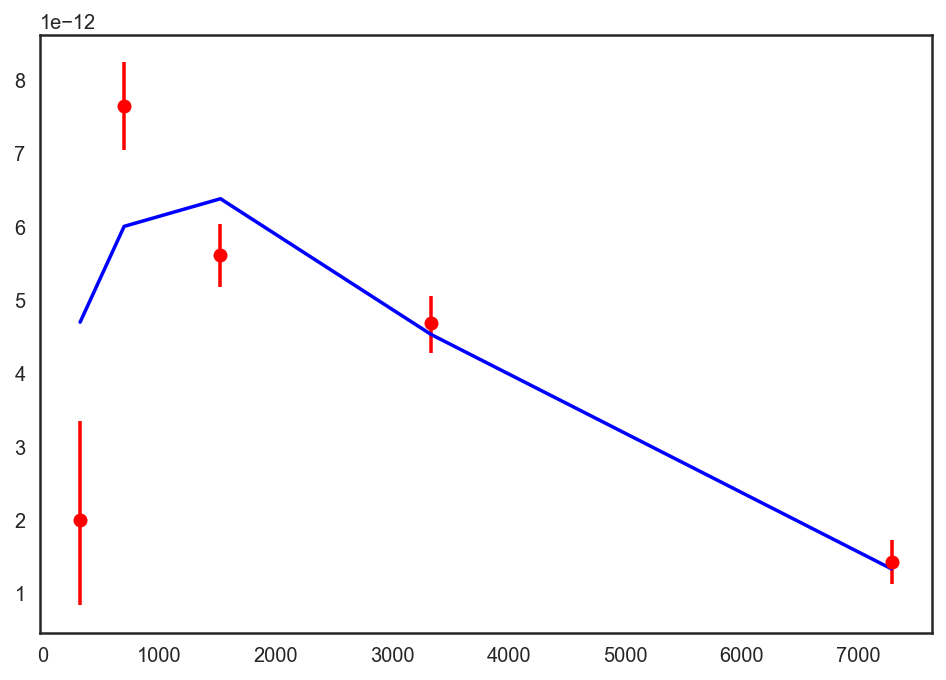

In [25]:
plt.plot(E,model_infer,'b');
plt.errorbar(E,flux,[error_u,error_d],fmt='o',color='r');

In [26]:
nwalkers = 120
ndim = len(p_list)/2

In [27]:
z = np.zeros((ndim,nwalkers))

In [28]:
h = 1e-2

pos_i=[]


for i in range(ndim):
    z[i,:] = result.x[i] + h*np.random.randn(nwalkers)

for i in range(nwalkers):
    pos_i.append(np.array([z[0,i],z[1,i],z[2,i]]))

In [29]:
b_steps, steps = 500, 1500

In [30]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, 
                                args=(flux,error,E,p_list),
                                threads = 2)

In [31]:
pos,prob,state=sampler.run_mcmc(pos_i, b_steps)

In [32]:
print sampler.acceptance_fraction.mean()

0.6454000000000001


In [33]:
sampler.reset()

In [34]:
_, _, _ = sampler.run_mcmc(pos, steps, rstate0=state)

In [35]:
print sampler.acceptance_fraction.mean()

0.63765


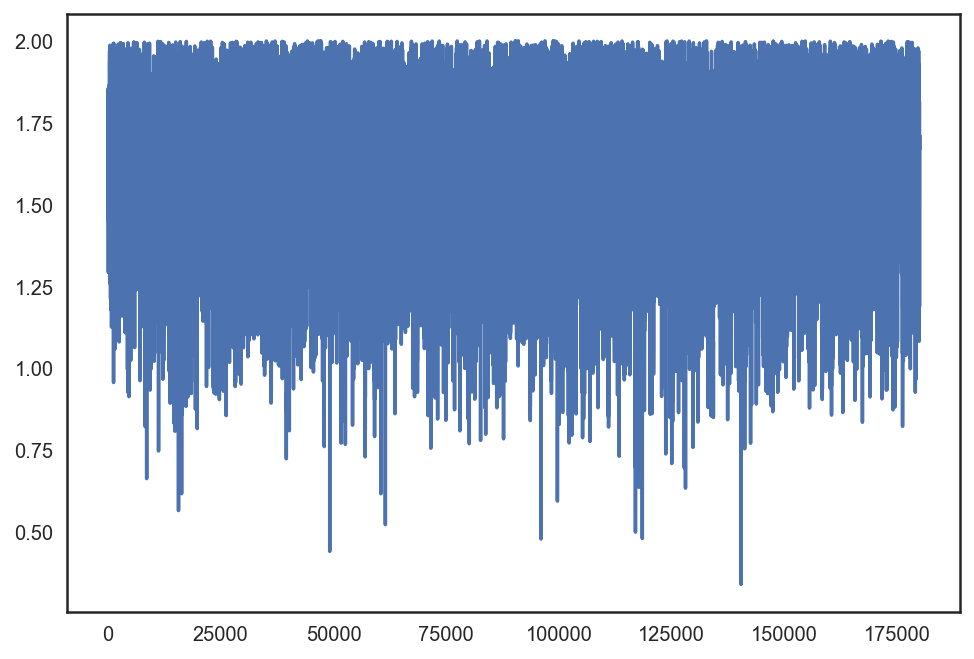

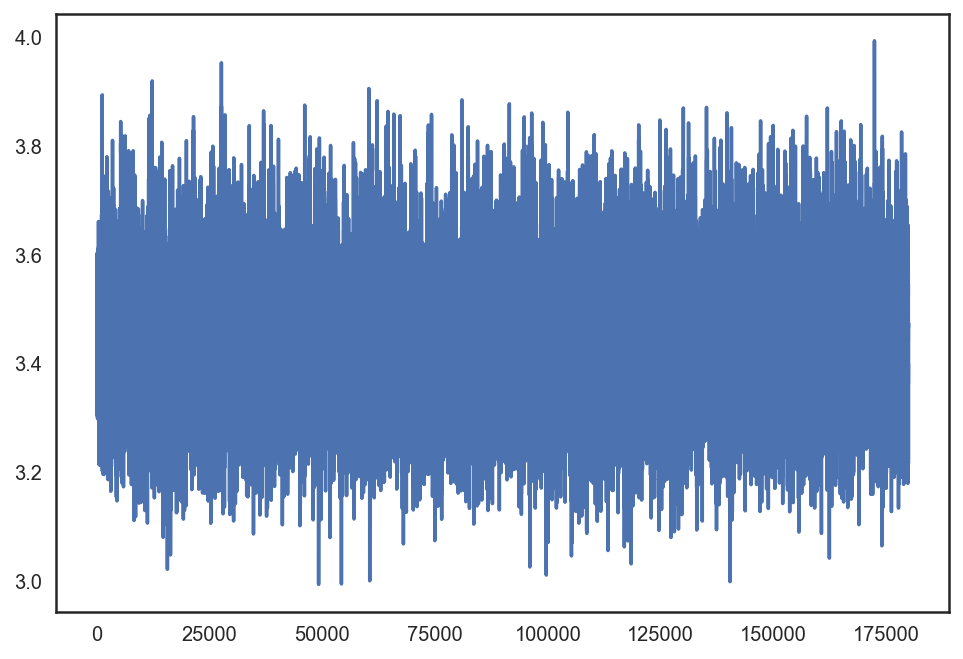

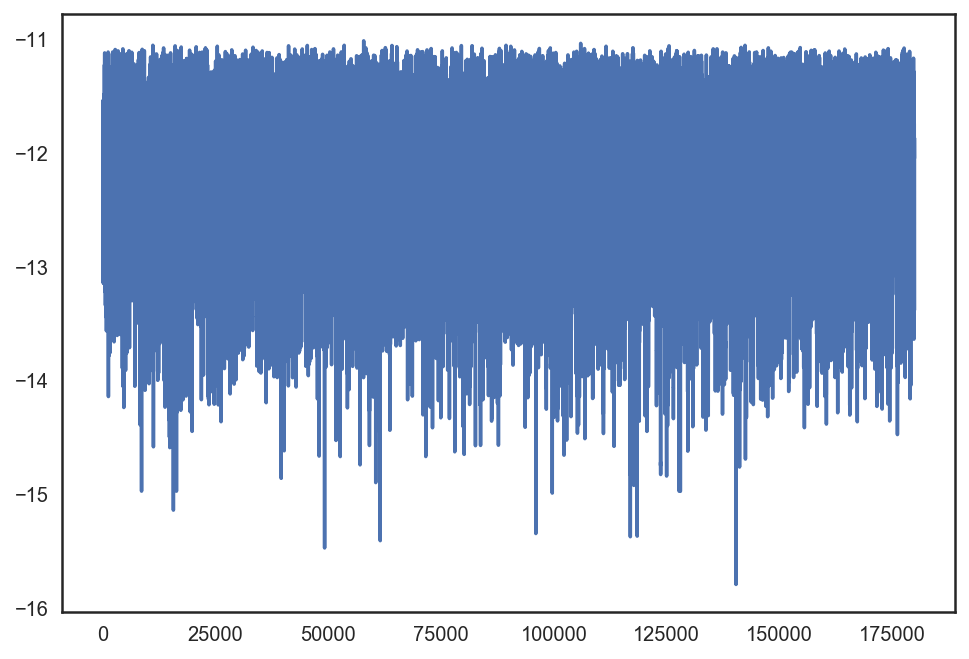

In [36]:
plt.figure()
plt.plot(sampler.flatchain[:,0]);
plt.figure()
plt.plot(sampler.flatchain[:,1]);
plt.figure()
plt.plot(sampler.flatchain[:,2]);

In [37]:
import corner as corner 

In [38]:
labels = [r'$\gamma$',r'$log_{10}E_c$',r'$log_{10}N_o$']

# Con background de la funete cercana 

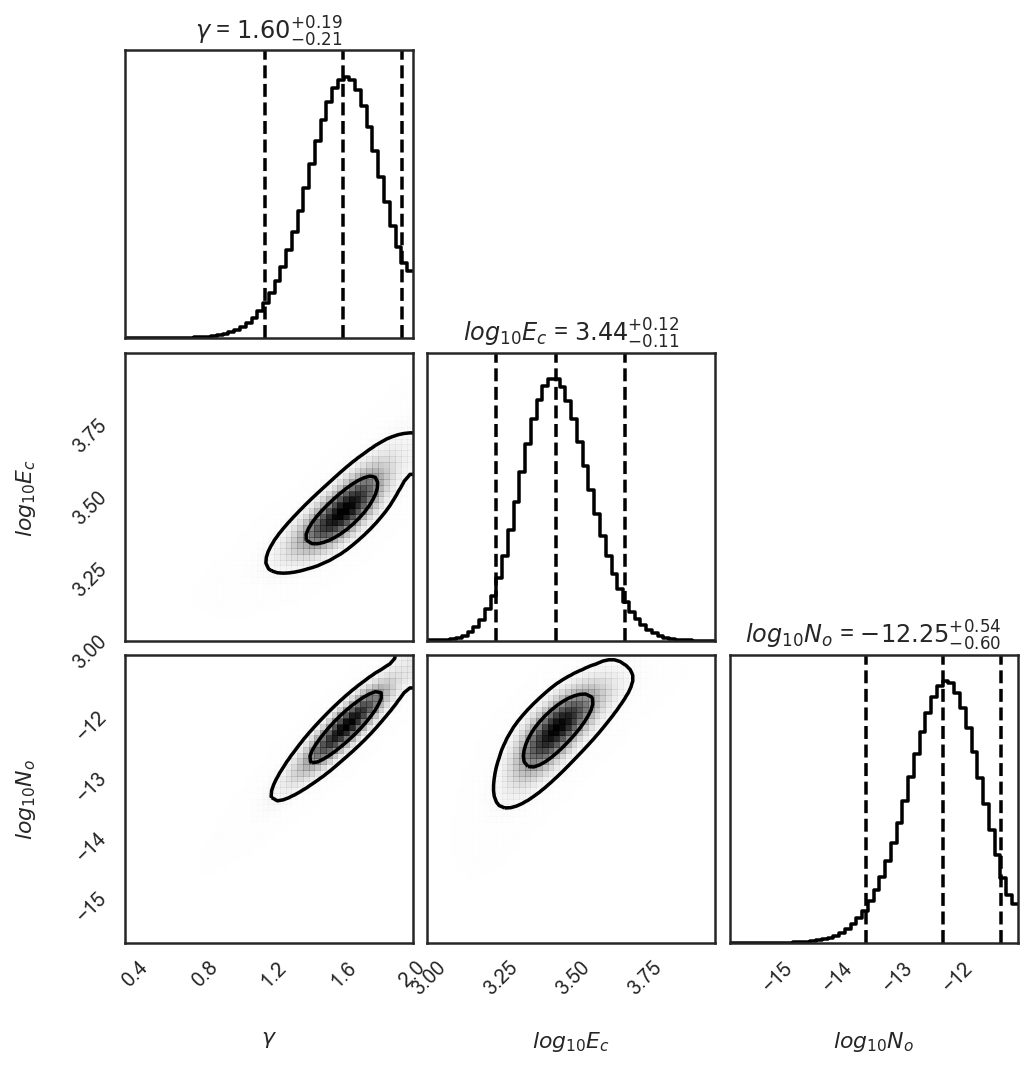

In [39]:
fig = corner.corner(sampler.flatchain,labels=labels,bins=50,plot_datapoints=False,smooth=2., 
                    smooth1d=2.,levels=(1.-np.exp(-0.5),1.-np.exp(-2.)),quantiles=[.025,0.5,0.975],show_titles=True);

In [40]:
fig.savefig('data_flux_wo_background_flux.pdf')